In [1]:
import os
from users.base_user import UserSim
from users.llm_user import LLMUserSim
from dialogue_sim import DialogueSimulator
import pe_modules
import users
import dataloaders
import llms
import jinja2
import argparse
import yaml
import json

/opt/homebrew/anaconda3/envs/llm-pe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get Item Data

### Shapes:
All 8 combinations of {red,blue},{large,small},{circle,triangle}

In [3]:
with open('data/shapes.json') as f:
    shapes = json.load(f)
shapes

{'0': {'name': 'Red Large Circle', 'description': 'Red Large Circle'},
 '1': {'name': 'Red Large Triangle', 'description': 'Red Large Triangle'},
 '2': {'name': 'Red Small Circle', 'description': 'Red Small Circle'},
 '3': {'name': 'Red Small Triangle', 'description': 'Red Small Triangle'},
 '4': {'name': 'Blue Large Circle', 'description': 'Blue Large Circle'},
 '5': {'name': 'Blue Large Triangle', 'description': 'Blue Large Triangle'},
 '6': {'name': 'Blue Small Triangle', 'description': 'Blue Small Circle'},
 '7': {'name': 'Blue Small Triangle', 'description': 'Blue Small Triangle'}}

### Clothing

all 8 combinations of {Men's, Women's}, {Black, Red}, {Shoes,T-Shirt}

In [4]:
with open('data/clothing.json') as f:
    clothing = json.load(f)
clothing

{'0': {'name': "Men's Black Shoes", 'description': "Men's Black Shoes"},
 '1': {'name': "Men's Black T-Shirt", 'description': "Men's Black T-Shirt"},
 '2': {'name': "Men's Red Shoes", 'description': "Men's Red Shoes"},
 '3': {'name': "Men's Red T-Shirt", 'description': "Men's Red T-Shirt"},
 '4': {'name': "Women's Black Shoes", 'description': "Women's Black Shoes"},
 '5': {'name': "Women's Black T-Shirt",
  'description': "Women's Black T-Shirt"},
 '6': {'name': "Women's Red Shoes", 'description': "Women's Red Shoes"},
 '7': {'name': "Women's Red T-Shirt", 'description': "Women's Red T-Shirt"}}

# Interaction Histories

In [5]:
#format: { <aspect>/"not "+<aspect> : {query: <query>, response: <"Yes"/"No>, asepect: <aspect>}}
easy_color_interactions = {
'blue' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue' }],
'not blue' : [{'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'}]
}

In [6]:
easy_shape_interactions = {
'triangle' : [{'query':'Are you looking for something triangular?', 'response':'yes','aspect key': 'shape', 'aspect value': 'triangle' }],
'not triangle' : [{'query':'Are you looking for something triangular?', 'response':'no','aspect key': 'shape', 'aspect value': 'triangle'}]
}

In [7]:
easy_size_interactions = {
'large' : [{'query':'Are you looking for something large?', 'response':'yes','aspect key': 'shape', 'aspect value': 'large' }],
'not large' : [{'query':'Are you looking for something large?', 'response':'no','aspect key': 'shape', 'aspect value': 'large'}]
}

# Preprocessing functions


In [8]:
#concatenates a single query and response
def concatenate(interactions):
    pref = ""
    for interaction in interactions:
        new_pref = 'Query: ' + interaction['query'] + '\nResponse: ' + interaction['response'] 
        pref += new_pref
    return pref

In [9]:
#Aspect only if yes, not+aspect if no
def aspect_value_only(interactions):
    pref = ""
    for i, interaction in enumerate(interactions):
        if interaction['response'] == 'yes':
            new_pref = interaction['aspect value']
            pref += new_pref
        elif interaction['response'] == 'no':
            new_pref = 'not ' + interaction['aspect value']
            pref += new_pref
        if not (i == (len(interactions)-1)):
            pref += ", "
    return pref

In [10]:
def aspect_key_value(interactions):
   pref = ""
   for i, interaction in enumerate(interactions):
      negation = ""
      if interaction['response'] == 'no':
         negation = "not "
      pref += "%s: %s%s" % (interaction['aspect key'], negation, interaction['aspect value'])
      if not (i == (len(interactions)-1)):
         pref += ", "
   return pref

# Entailement Functions


### FB mnli

In [11]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [12]:
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

#no gpu use for notebook
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#temp = nli_model.to(device) #assignment prevents notebook cell print

In [13]:
def mnli(preference,items) -> list:
#get like probs for preference (str, e.g, "not blue") and all item descriptions
    
    hypotheses = [preference] * len(items)
    
    premises = [item['description'] for item in items.values()]

    inputs = nli_tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt", max_length=nli_tokenizer.model_max_length)

    # Ensure the tokenized inputs don't exceed the max length
    if inputs.input_ids.size(1) > nli_tokenizer.model_max_length:
        print(f"Warning: One or more tokenized inputs exceed the max length of {tokenizer.model_max_length} and will be truncated.")

    #no gpu use for notebook
    #inputs = inputs.to(device)

    with torch.no_grad():
        outputs = nli_model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    #get entailement probs
    entailment_probs = predictions[:, 2].tolist()
    return entailment_probs

In [14]:
# Aspect-based GPT
from item_scorers.llm_logprob_scorer import LLMLogprobScorer
aspect_config = {"llm": {
                    "llm_name": "GPTCompletion",
                    "model": "gpt-3.5-turbo-instruct",
                    "template_dir": "./templates",
                    "like_probs_template": "aspect_pref_query.jinja2",
                },
          "logging": {
                    "level": "DEBUG",
                    "disabled": False
                }
        }
aspect_llm_scorer = LLMLogprobScorer(aspect_config)

def aspect_gpt_prompting(preference,items) -> list: # Wrapper function for LLMLogprobScorer.score_items()
    results_dict = aspect_llm_scorer.score_items(preference, items)
    results_list = []
    for item_id in results_dict:
        results_list.append(results_dict[item_id])
    return results_list

In [15]:
# Concat-based GPT (requires different template file)
concat_config = {"llm": {
                    "llm_name": "GPTCompletion",
                    "model": "gpt-3.5-turbo-instruct",
                    "template_dir": "./templates",
                    "like_probs_template": "concat_pref_query.jinja2",
                },
          "logging": {
                    "level": "DEBUG",
                    "disabled": False
                }
        }
concat_llm_scorer = LLMLogprobScorer(concat_config)

def concat_gpt_prompting(preference,items) -> list: # Wrapper function for LLMLogprobScorer.score_items()
    results_dict = concat_llm_scorer.score_items(preference, items)
    results_list = []
    for item_id in results_dict:
        results_list.append(results_dict[item_id])
    return results_list

### Cross encoder

In [16]:
from sentence_transformers import CrossEncoder
ce_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

In [17]:
def ce(preference,items) -> list:
    inputs = [(preference,item['description'])  for item in items.values()]
    outputs = ce_model.predict(inputs)
    return torch.sigmoid(torch.from_numpy(outputs)).tolist()

# Entailment Pipelines

In [18]:
#format: [
#{name: #short name for plot axis label, preprocessing: #preprocessing function handle, entailement function handle}
#...
#]
pipelines = [
    {'name': 'mnli aspect value', 'preprocessing': aspect_value_only, 'entailment': mnli},
    {'name': 'mnli concatenated', 'preprocessing': concatenate, 'entailment': mnli},
    {'name': 'mnli key value', 'preprocessing': aspect_key_value, 'entailment': mnli},
    {'name': 'ce aspect value', 'preprocessing': aspect_value_only, 'entailment': ce},
    {'name': 'ce concatenated', 'preprocessing': concatenate, 'entailment': ce},
    {'name': 'ce key value', 'preprocessing': aspect_key_value, 'entailment': ce},
    # {'name': 'gpt aspect value', 'preprocessing': aspect_value_only, 'entailment': aspect_gpt_prompting},
    # {'name': 'gpt concatenated', 'preprocessing': concatenate, 'entailment': concat_gpt_prompting}
]

# Experiments

In [35]:
#plot pipeline results for each interaction (a seperate graph) and for each item (seperate categories on x axis)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


def plot_entailment_pipeline(pipelines, interactions, items):
    colors = mpl.colormaps['viridis']
    colors = [colors(i) for i in np.linspace(0, 1, len(pipelines))]

    
    for interaction_key, interaction in interactions.items():
        # Initialize data structure for plotting
        plot_data = {item_key: [] for item_key in items.keys()}
        
        for pipeline in pipelines:
            # Preprocess interaction
            preference = pipeline['preprocessing'](interaction)
            
            # Run entailment for each item
            like_probabilities = pipeline['entailment'](preference, items)
            
            # Add results to plot_data
            for item_key, probability in zip(items.keys(), like_probabilities):
                plot_data[item_key].append(probability)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.title('Preference: ' + interaction_key)
        
        # Create bars for each item and pipeline
        for idx, (item_key, probabilities) in enumerate(plot_data.items()):
            for i, probability in enumerate(probabilities):
                plt.bar(idx + 0.1*i, probability, width=0.1, color=colors[i], label=pipeline['name'] if idx == 0 else "")

        # Set x-axis labels
        item_labels = [items[key]['name'] if len(items[key]['name']) <= 30 else key for key in items.keys()]
        plt.xticks([i + 0.1 * (len(pipelines) - 1) / 2 for i in range(len(items))], item_labels, rotation=45)
        plt.ylabel('Like Probability')

        # Create a legend
        handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(pipelines))]
        plt.legend(handles, [p['name'] for p in pipelines], title='Pipelines')

        plt.ylim(0,1)

        plt.show()


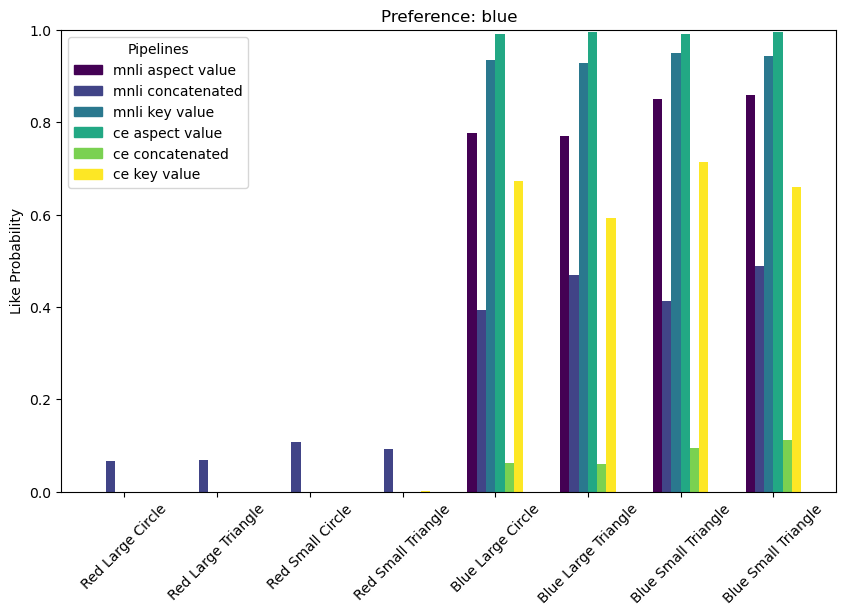

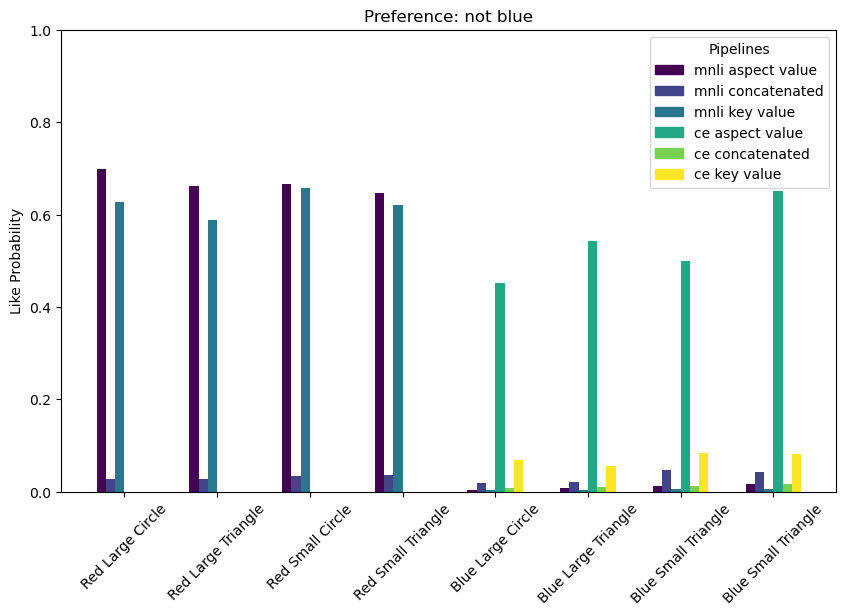

In [33]:
plot_entailment_pipeline(pipelines, easy_color_interactions, shapes)

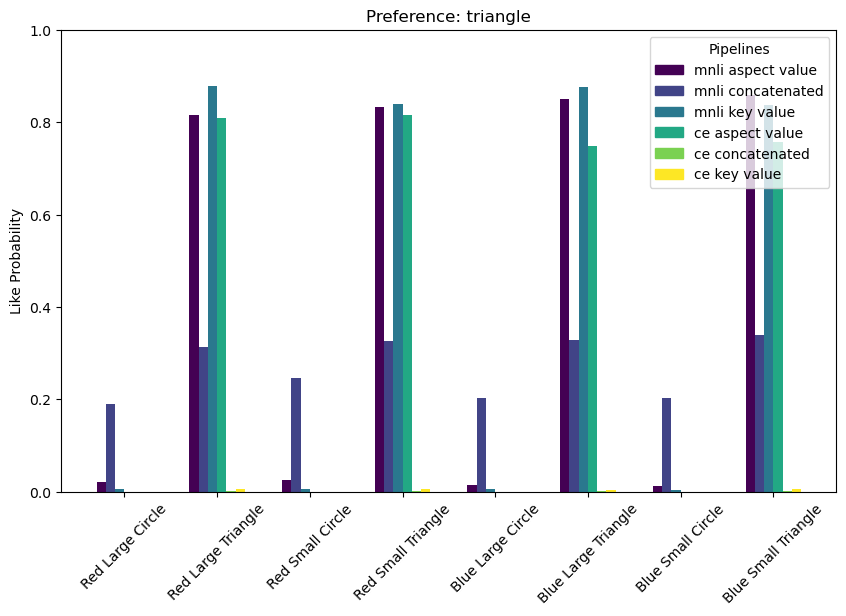

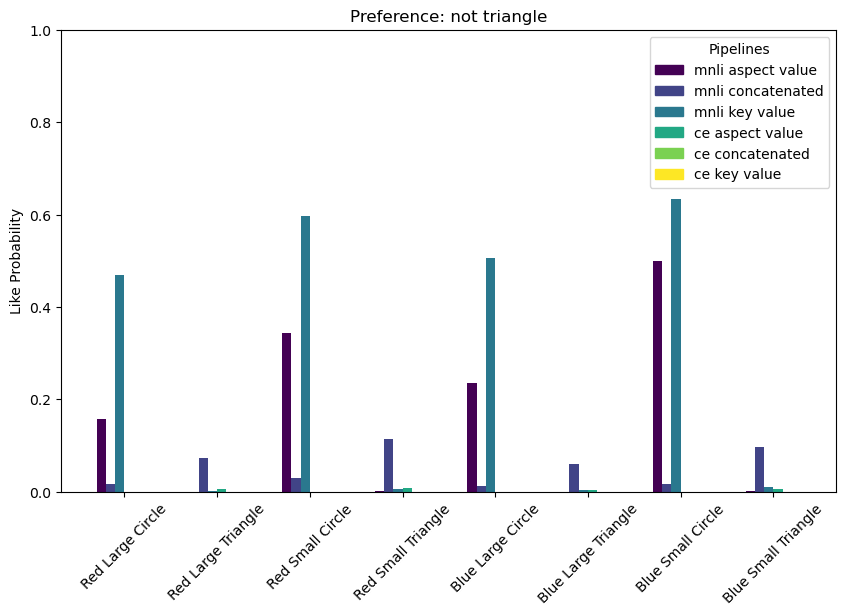

In [23]:
plot_entailment_pipeline(pipelines, easy_shape_interactions, shapes)

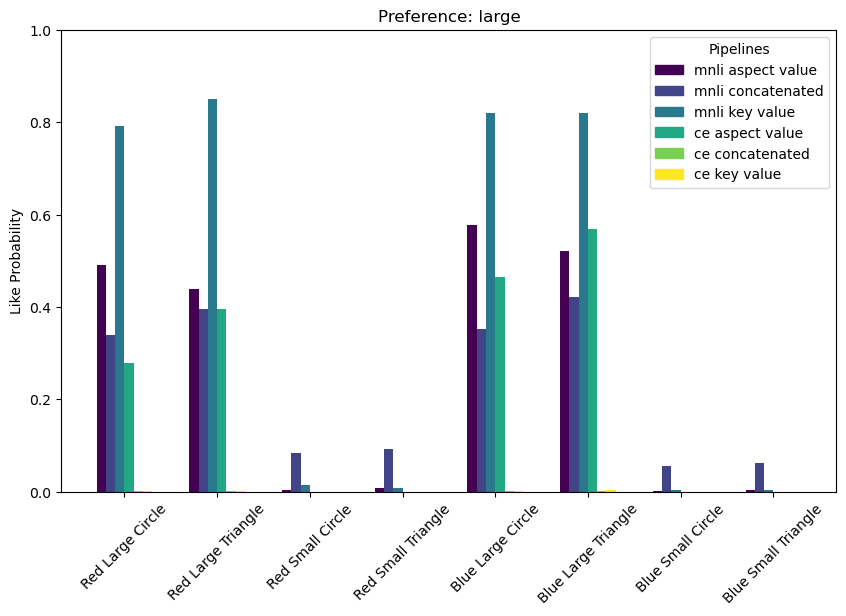

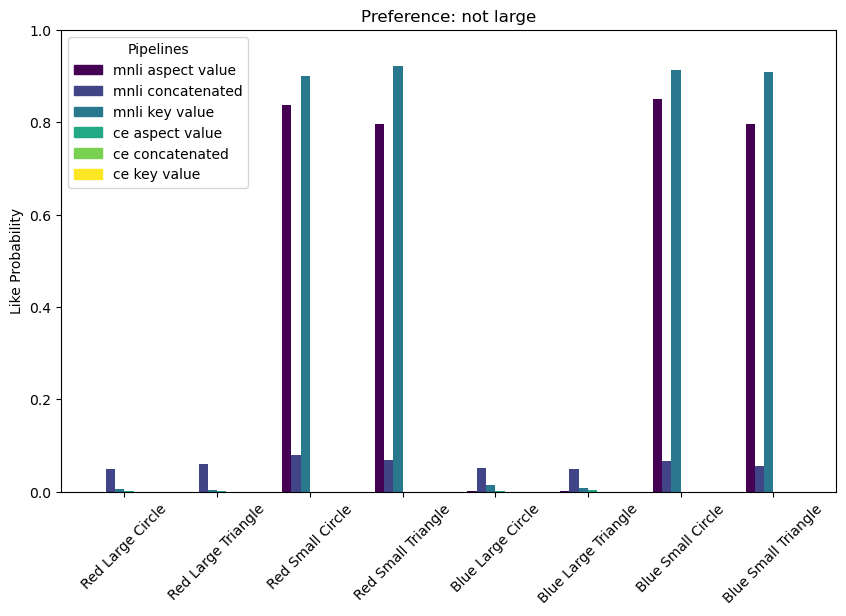

In [24]:
plot_entailment_pipeline(pipelines, easy_size_interactions, shapes)

### FB mnli more experiments (neutral vs no neutral)


In [ ]:
hypotheses = ['not small red circle',
            'This item would be liked by someone who responed as follows: \n Query:  Are you looking for a small red circle? \n Response:  No',
            'Query:  Are you looking for a small red circle? \n Response:  No',
            'Men\'s blue shirt',
           'blue shirt',
             'blue',
             'Query: Are you looking for something blue? \nResponse: yes']
           
premises = ['large red circle', 'large red circle','large red circle','blue shirt','Men\'s blue shirt','Red Large Circle','Red Large Circle']

inputs = nli_tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt", max_length=nli_tokenizer.model_max_length)

# Ensure the tokenized inputs don't exceed the max length
if inputs.input_ids.size(1) > nli_tokenizer.model_max_length:
    print(f"Warning: One or more tokenized inputs exceed the max length of {max_length} and will be truncated.")

#no gpu use for notebook
#inputs = inputs.to(device)
    
with torch.no_grad():
    outputs = nli_model(**inputs)

#### Throwing away neutral:


In [ ]:
# as per: https://huggingface.co/facebook/bart-large-mnli
# throw away "neutral" (dim 1) and take the probability of
# "entailment" (2) as the probability of the label being true
entail_contr_logits = outputs[0][:,[0,2]]
entail_contr_probs  = torch.nn.functional.softmax(entail_contr_logits, dim=-1)

#entailment_probs = predictions[:, 2].tolist()
entail_contr_probs

#### Keeping neutral:


In [ ]:
all_probs = torch.nn.functional.softmax(outputs[0],dim=-1)
all_probs

In [ ]:
#Anton observation dec 12:
#logits are [contradicts, neutral, entails]

#Aspect negation format works OK
#-------------------------------
#premise = 'not small red circle'
#hypothesis = '''
#large red circle'''
#logits: [-0.8607, -0.2254,  1.5746]

#Raw query response format works bad
#-------------------------------
#premise = 'large red circle'
#hypothesis = '''
#This item would be liked by someone who responed as follows:
#Query:  Are you looking for a small red circle? \n Response:  No'''
#[ 2.7382, -1.1287, -2.2011]
#Anton observation Dec 12: neutral may only be output when the hypothesis is a generalization of the premise (e.g. P = soccer, H = world cup soccer)

#### Sentence-Transformer Cross Encoder

In [ ]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

In [72]:
test_CE_input =  [('not small red circle', 'large red circle'),
                  ('This item would be liked by someone who responed as follows: \n Query:  Are you looking for a small red circle? \n Response:  No','large red circle'),
                  ('Query:  Are you looking for a small red circle? \n Response:  No', 'large red circle'),
                  ('Men\'s blue shirt', 'blue shirt'),
                 ('blue shirt', 'Men\'s blue shirt'),
                 ('Blue Large Circle','not blue')]

output = ce_model.predict(test_CE_input)

torch.sigmoid(torch.from_numpy(output)).tolist()

[0.9460662007331848,
 6.547756493091583e-05,
 0.9145389795303345,
 0.728950560092926,
 0.9942330718040466,
 0.01334536261856556]

## Multiple Aspects

In [25]:
#format: { <aspect>/"not "+<aspect> : {query: <query>, response: <"Yes"/"No>, asepect: <aspect>}}
compound_color_size_interactions = {
'blue large' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'yes','aspect key': 'size', 'aspect value': 'large'}],
'blue not large' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'no','aspect key': 'size', 'aspect value': 'large'}],
'not blue large' : [{'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'no','aspect key': 'size', 'aspect value': 'large'}],
'not blue not large' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'no','aspect key': 'size', 'aspect value': 'large'}],
}

compound_shape_color_interactions = {
'circle blue' : [{'query':'Are you looking for something circular?', 'response':'yes','aspect key': 'shape', 'aspect value': 'circle'},
                {'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'}],
'circle not blue' : [{'query':'Are you looking for something circular?', 'response':'yes','aspect key': 'shape', 'aspect value': 'circle'},
                {'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'}],
'not circle blue' : [{'query':'Are you looking for something circular?', 'response':'no','aspect key': 'shape', 'aspect value': 'circle'},
                {'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'}],
'not circle not blue' :[{'query':'Are you looking for something circular?', 'response':'no','aspect key': 'shape', 'aspect value': 'circle'},
                {'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'}],
}

compound_color_size_shape_interactions = {
'blue large circle' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'yes','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'yes','aspect key': 'shape', 'aspect value': 'circle'}],
'blue large not circle' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'yes','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'no','aspect key': 'shape', 'aspect value': 'circle'}],
'blue not large circle' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'no','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'yes','aspect key': 'shape', 'aspect value': 'circle'}],
'blue not large not circle' : [{'query':'Are you looking for something blue?', 'response':'yes','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'no','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'no','aspect key': 'shape', 'aspect value': 'circle'}],
'not blue large circle' : [{'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'yes','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'yes','aspect key': 'shape', 'aspect value': 'circle'}],
'not blue large not circle' : [{'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'yes','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'no','aspect key': 'shape', 'aspect value': 'circle'}],
'not blue not large circle' : [{'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'no','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'yes','aspect key': 'shape', 'aspect value': 'circle'}],
'not blue not large not circle' : [{'query':'Are you looking for something blue?', 'response':'no','aspect key': 'color', 'aspect value': 'blue'},
                {'query':'Are you looking for something large?', 'response':'no','aspect key': 'size', 'aspect value': 'large'},
                {'query':'Are you looking for something circular?', 'response':'no','aspect key': 'shape', 'aspect value': 'circle'}],
}


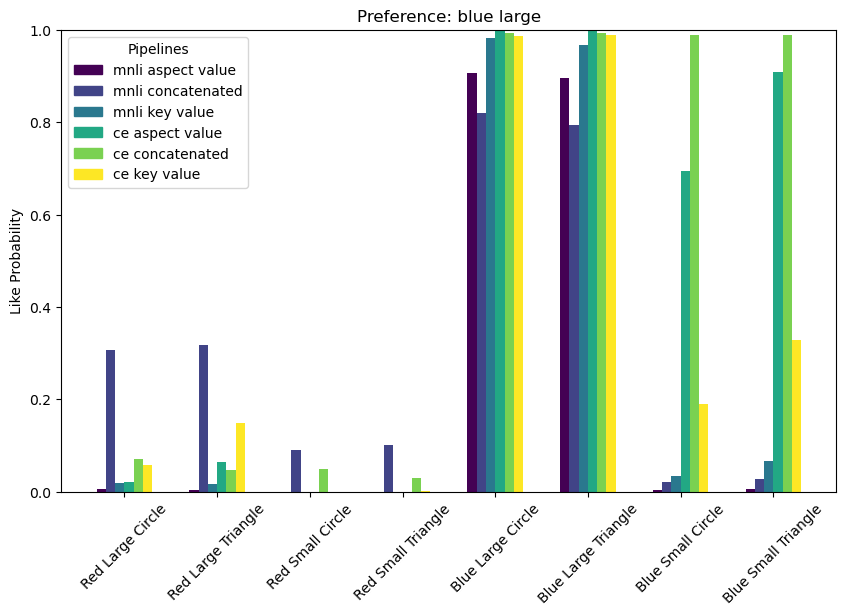

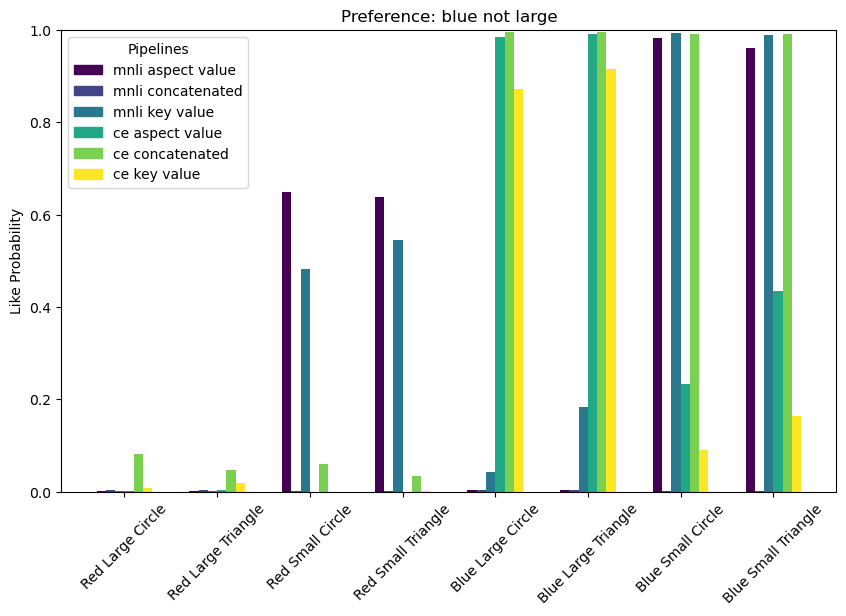

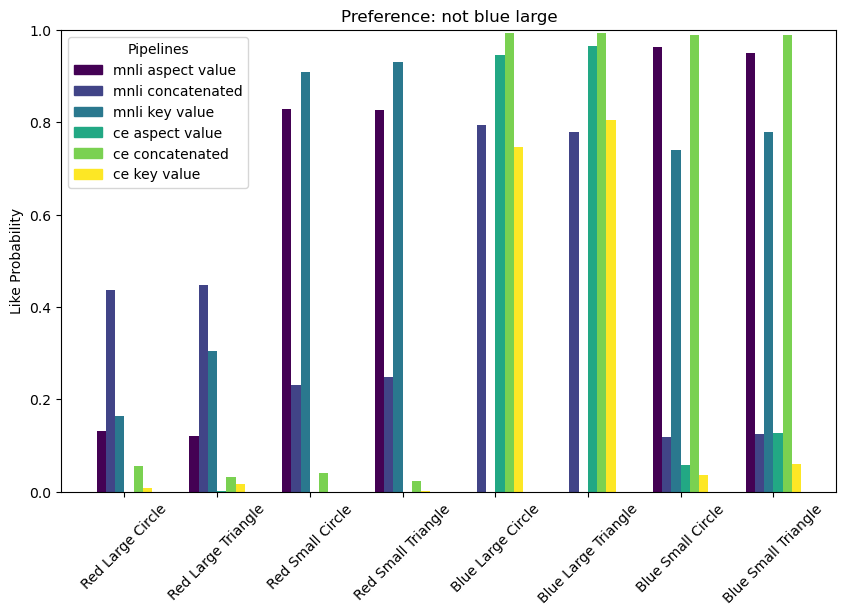

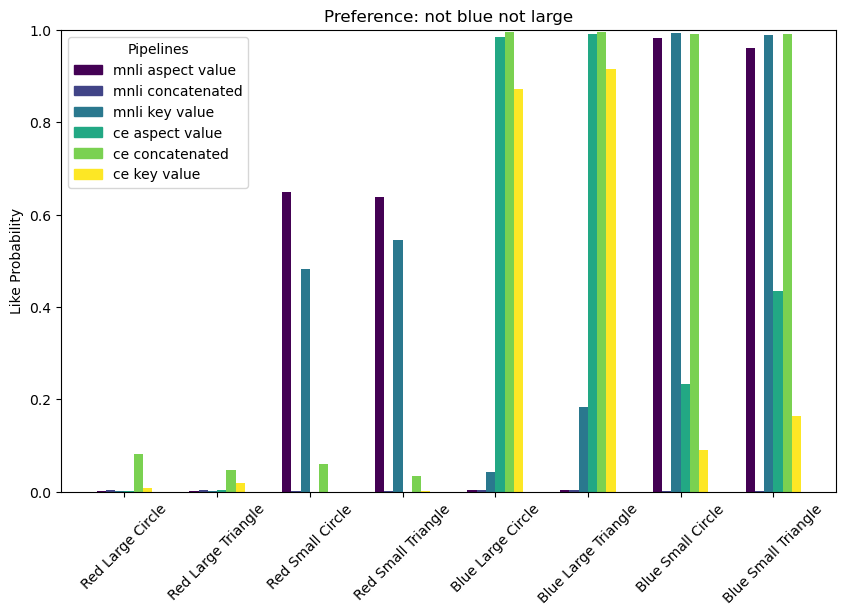

In [26]:
plot_entailment_pipeline(pipelines, compound_color_size_interactions, shapes)

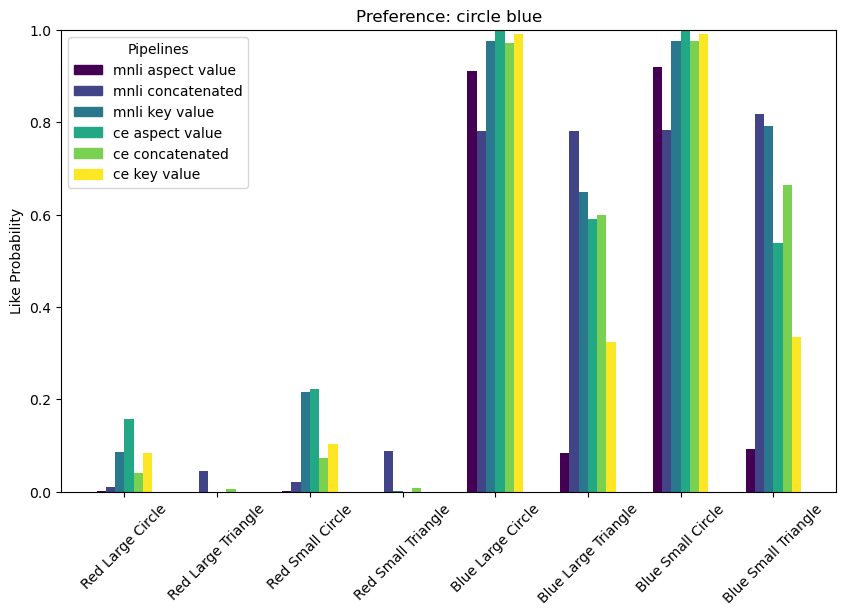

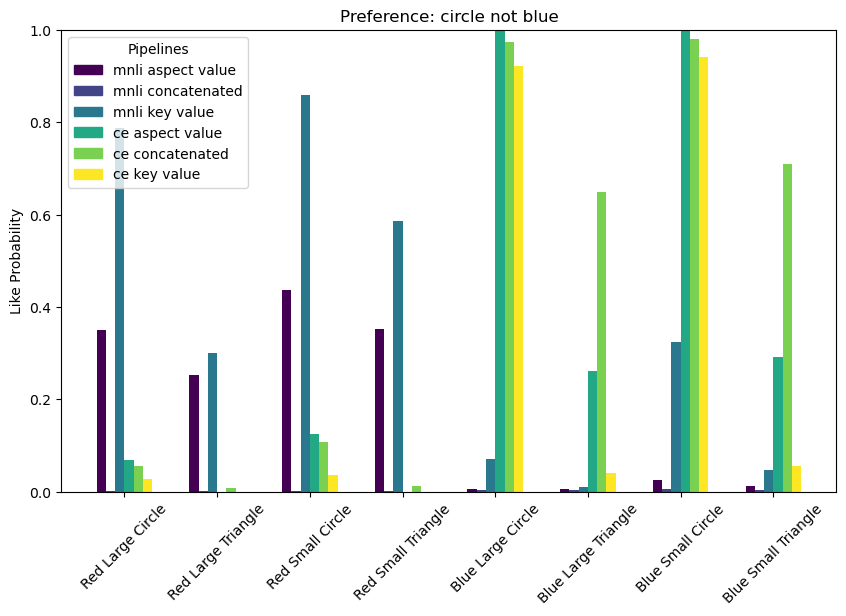

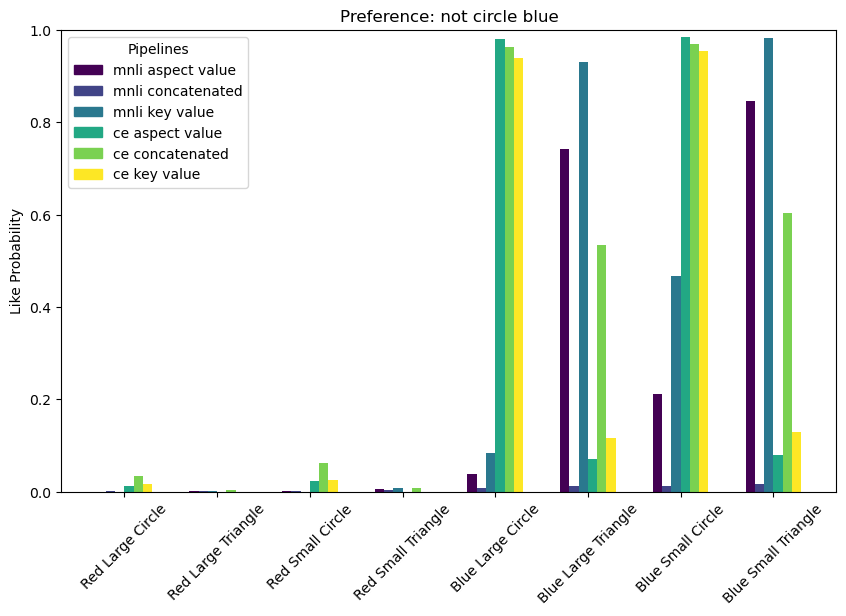

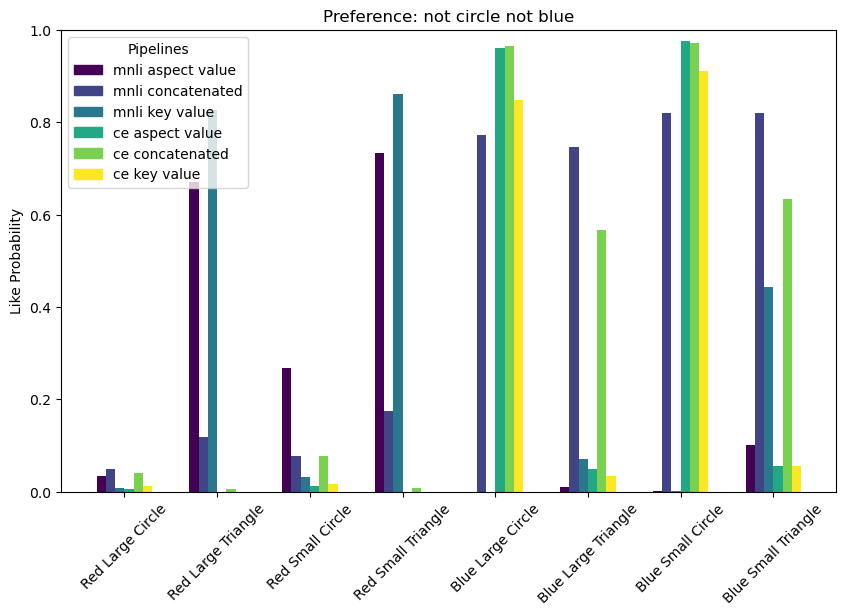

In [27]:
plot_entailment_pipeline(pipelines, compound_shape_color_interactions, shapes)

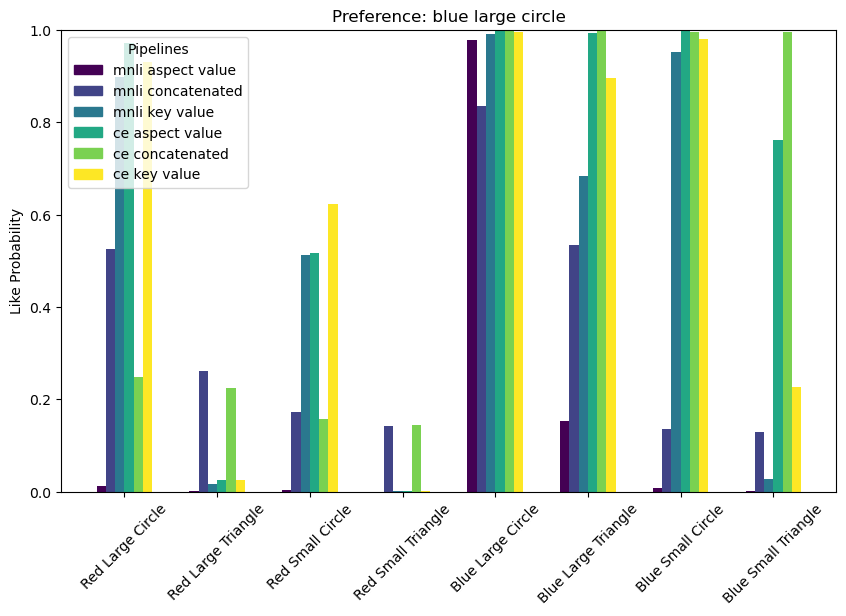

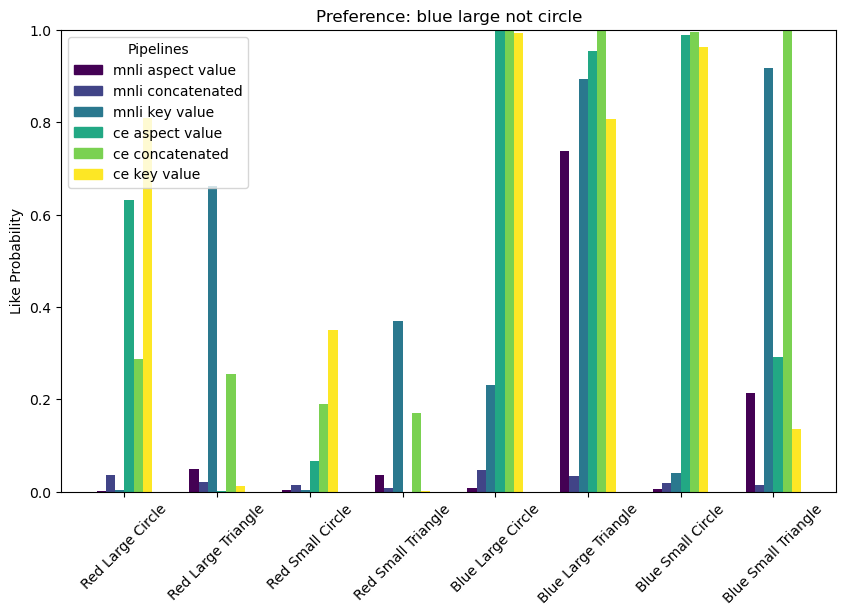

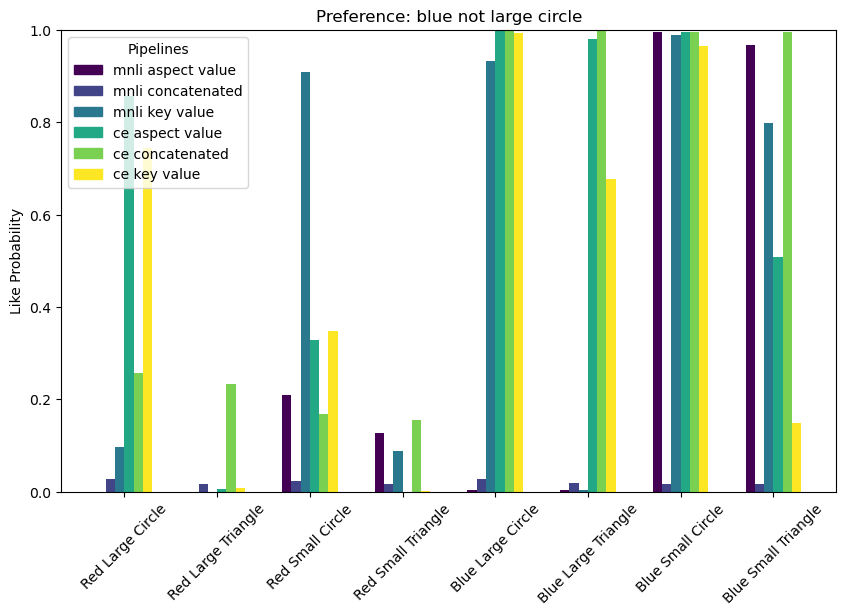

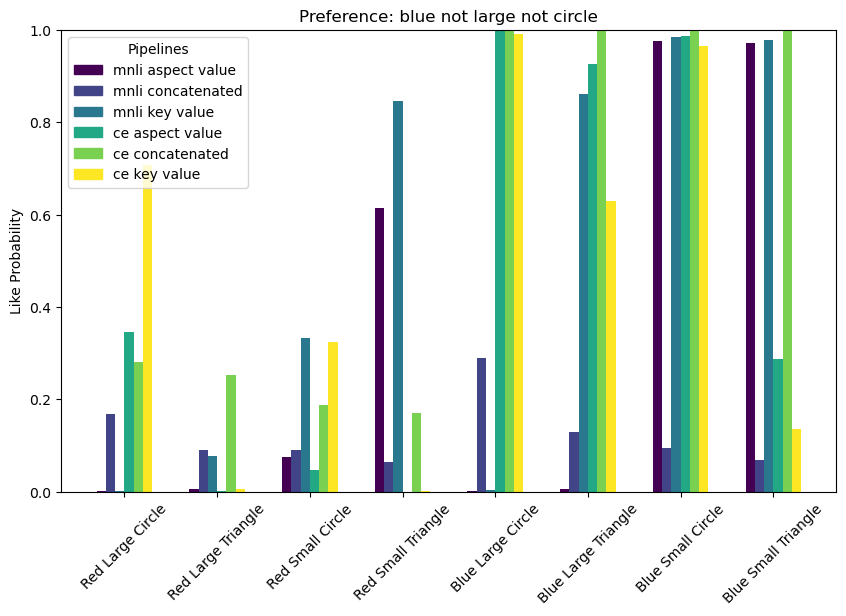

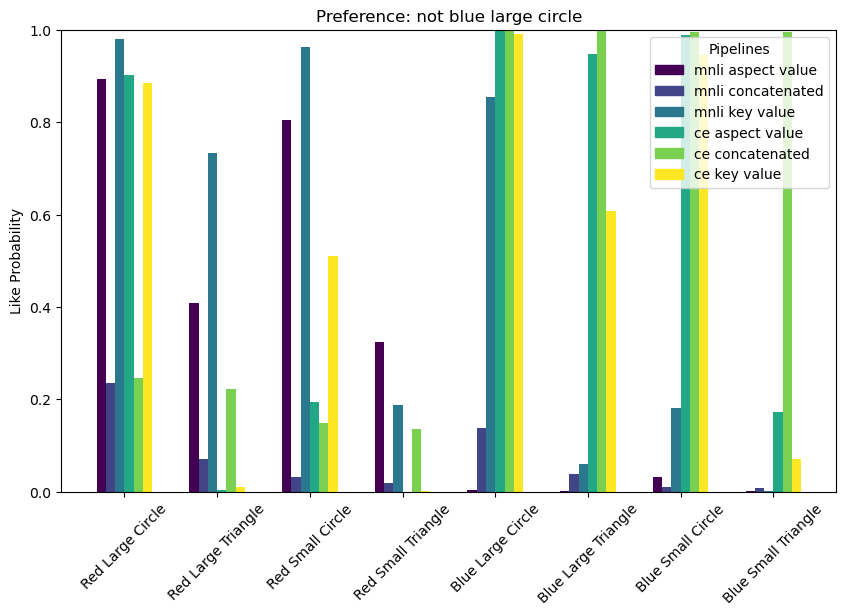

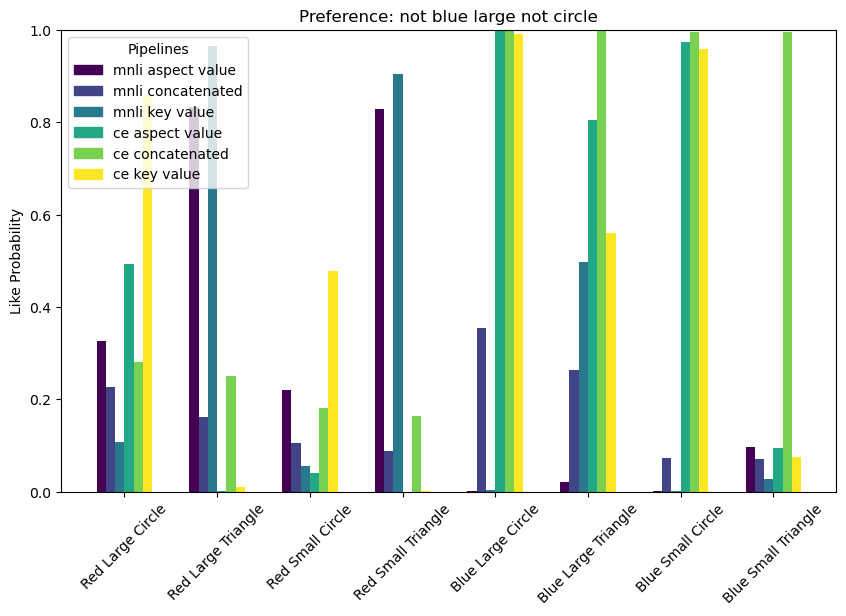

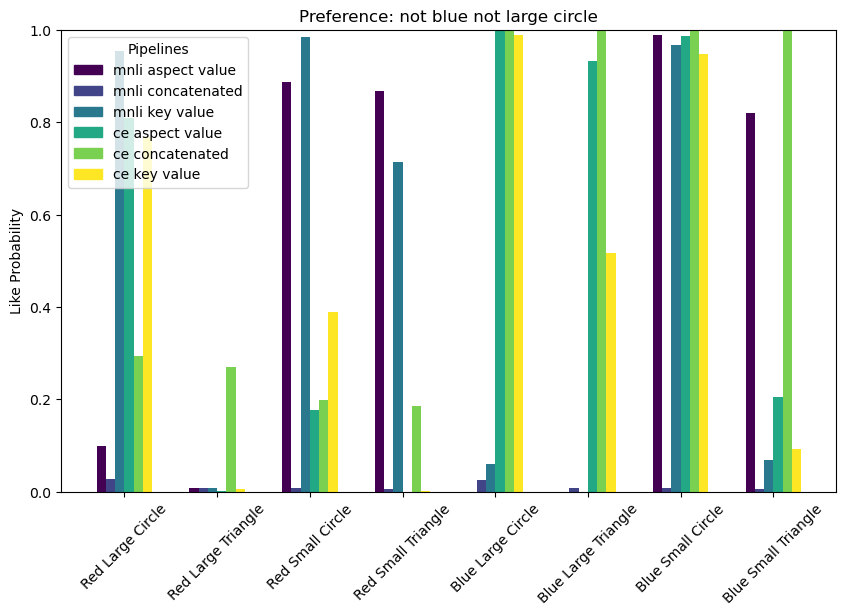

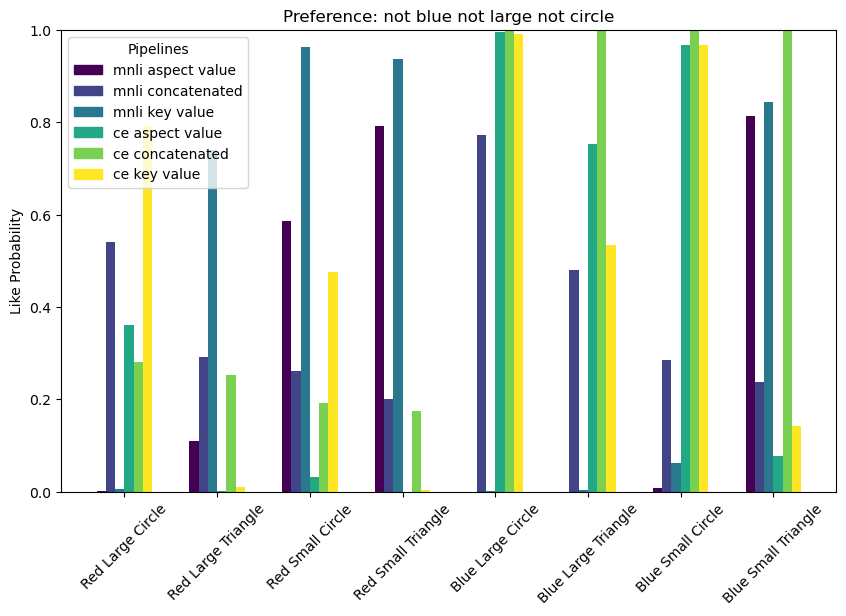

In [28]:
plot_entailment_pipeline(pipelines, compound_color_size_shape_interactions, shapes)

## MovieLens Testing

In [29]:
# Load in items
with open('data/movielens_2.json') as f:
    movies = json.load(f)
movies

{'1214': {'description': 'Horror, Sci-Fi, imdb top 250, aliens, sci-fi, suspense, thriller, tense, horror, atmospheric, outer space, space, space travel, suspenseful',
  'name': 'Alien (1979)'},
 '1240': {'description': 'Action, Sci-Fi, Thriller, Action, artificial intelligence, future, time travel, imdb top 250, arnold, Arnold Schwarzenegger, classic, cyborgs, dystopic future, highly quotable, robots',
  'name': 'Terminator, The (1984)'},
 '2571': {'description': 'Action, Sci-Fi, Thriller, alternate reality, artificial intelligence, cyberpunk, dystopia, philosophical, philosophy, sci-fi, virtual reality, Futuristic, post apocalyptic, surreal, thought-provoking',
  'name': 'Matrix, The (1999)'},
 '8874': {'description': 'Comedy, Horror, Simon Pegg, Very British and very funny!, zombies, black comedy, British, british comedy, comedy, dark comedy, dark humor, Edgar Wright, funny, hilarious',
  'name': 'Shaun of the Dead (2004)'},
 '46972': {'description': "Action, Comedy, Fantasy, IMAX, 

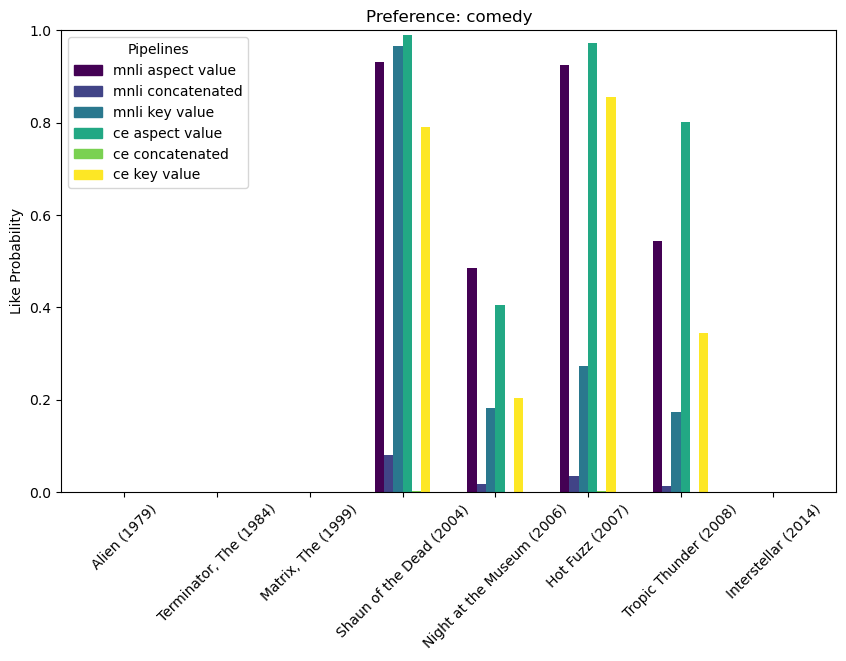

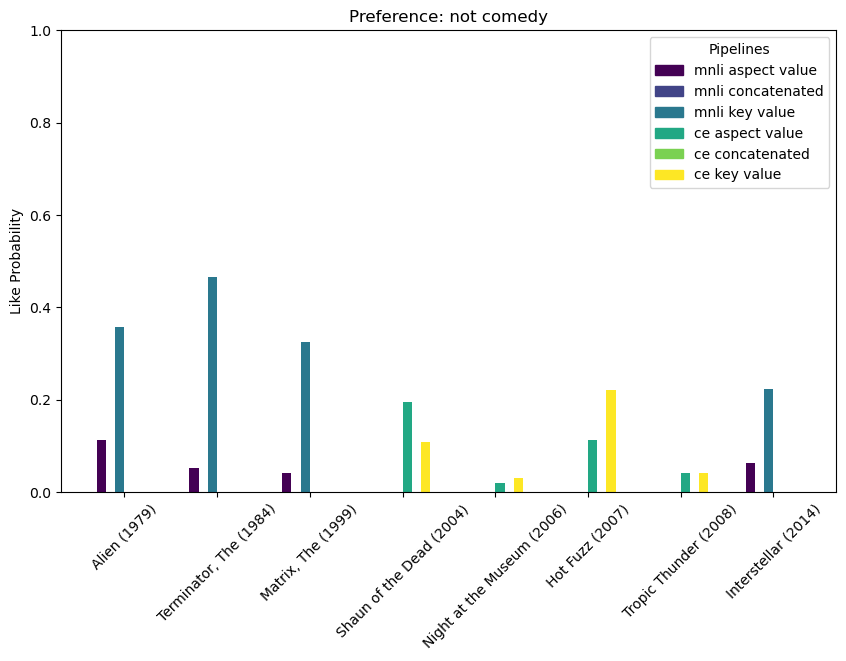

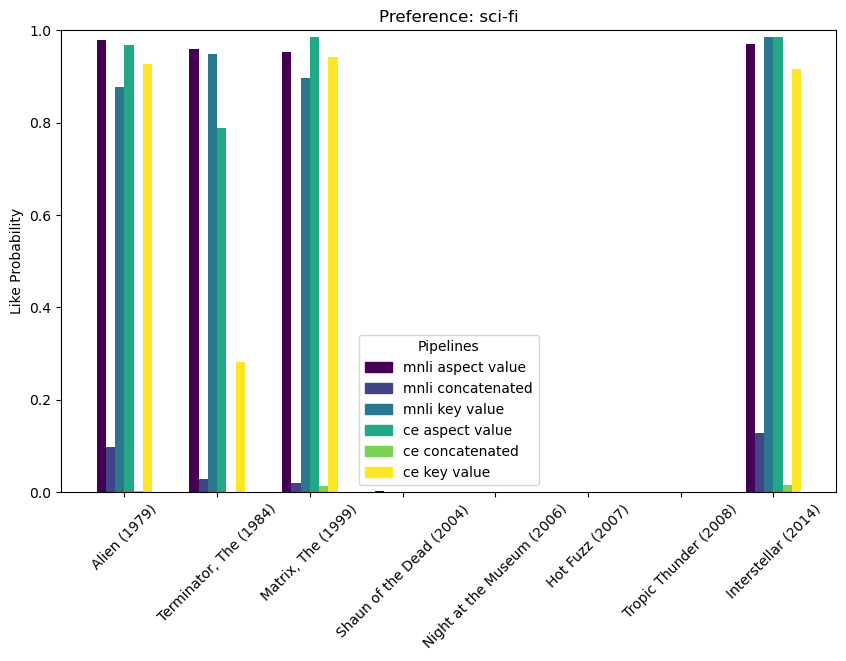

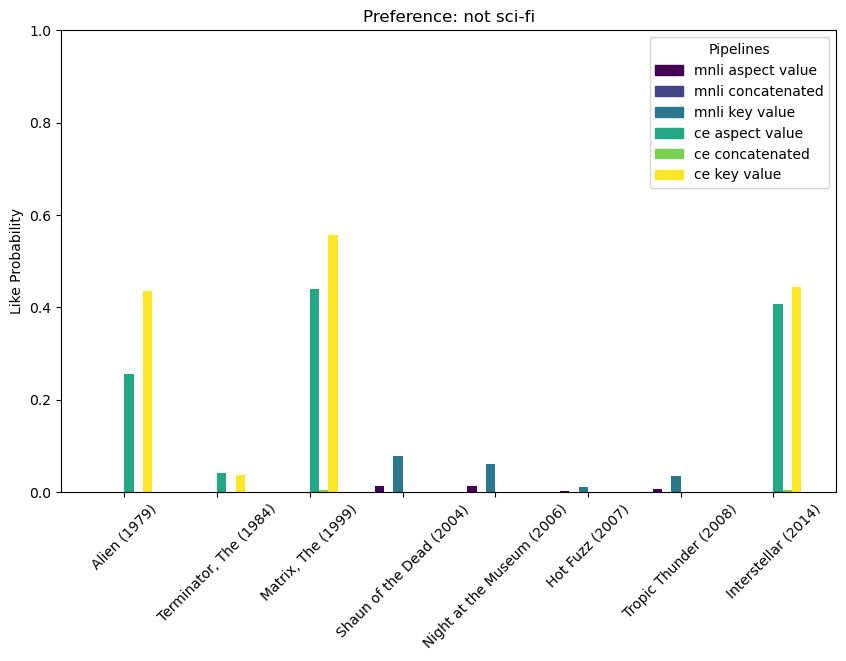

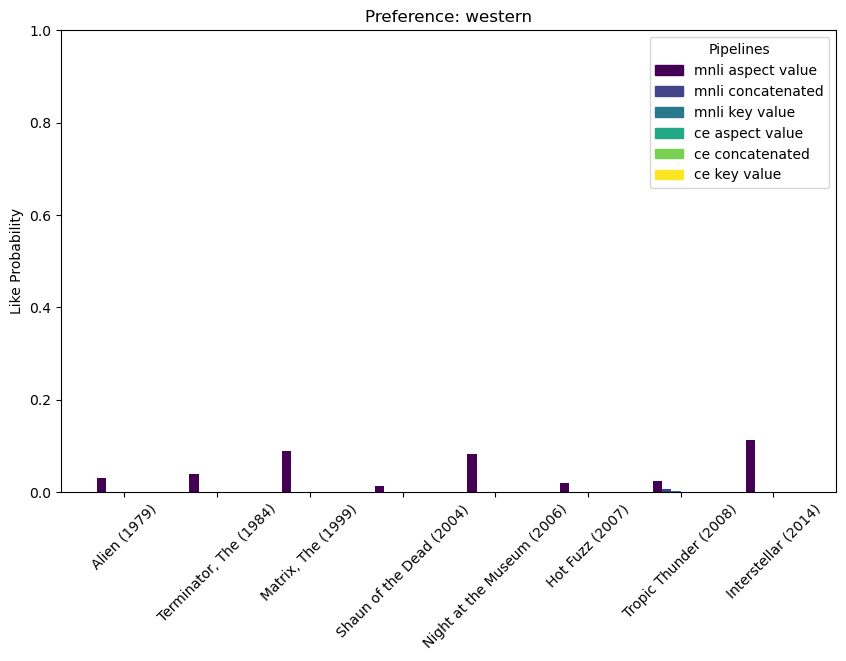

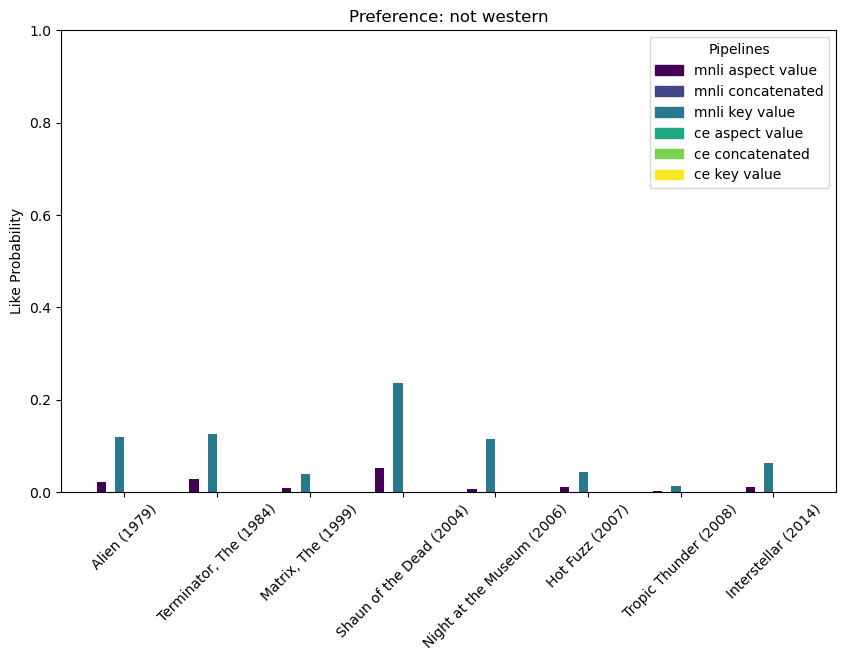

In [36]:
movie_genre_interactions = {
'comedy' : [{'query':'Do you like comedies?', 'response':'yes','aspect key': 'genre', 'aspect value': 'comedy' }],
'not comedy' : [{'query':'Do you like comedies?', 'response':'no','aspect key': 'genre', 'aspect value': 'comedy'}],
'sci-fi' : [{'query':'Do you like sci-fi?', 'response':'yes','aspect key': 'genre', 'aspect value': 'sci-fi' }],
'not sci-fi' : [{'query':'Do you like sci-fi?', 'response':'no','aspect key': 'genre', 'aspect value': 'sci-fi' }],
'western' : [{'query':'Do you like westerns?', 'response':'yes','aspect key': 'genre', 'aspect value': 'western' }],
'not western' : [{'query':'Do you like westerns?', 'response':'no','aspect key': 'genre', 'aspect value': 'western' }],
}

plot_entailment_pipeline(pipelines, movie_genre_interactions, movies)